In [1]:
import sklearn 
print (sklearn.__version__)

0.24.1


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
%matplotlib inline

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
X_train_init = train.drop(["label"], axis=1)
y_train_init = train["label"]

### STUDY

C:\Users\smrha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

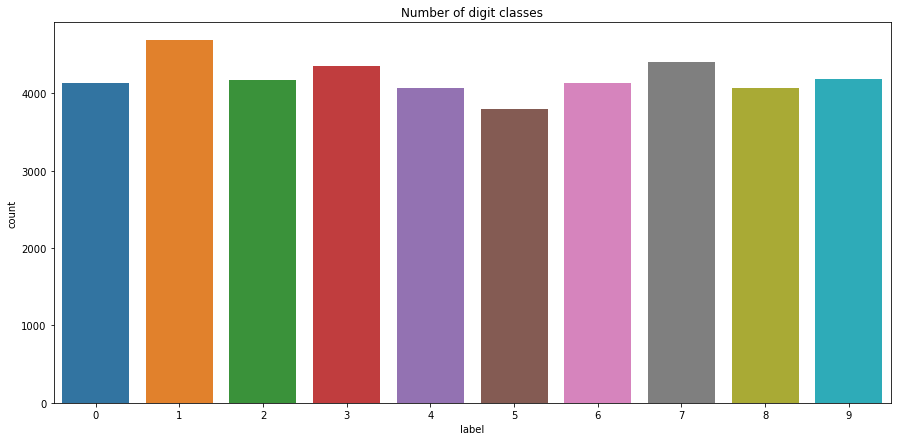

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
# visualize number of digits classes
plt.figure(figsize=(15,7))
sns.countplot(y_train_init)
plt.title("Number of digit classes")
y_train_init.value_counts()

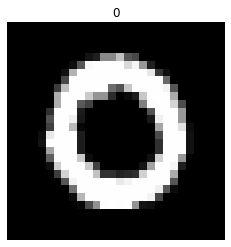

In [6]:
image = X_train_init.iloc[1].to_numpy()

img = image.reshape((28,28))

plt.imshow(img, cmap='gray')
plt.title(y_train_init.iloc[1])
plt.axis("off")
plt.show()

## PRE PROCESSING

In [7]:
# IMPORT KERAS FROM TENSORFLOW
from tensorflow import keras
from tensorflow.keras import layers


In [8]:
# Normalize the data

X_train_norm = X_train_init/255.0
X_test_norm = test/255.0


In [9]:
# Reshape to use a CNN processing a real image

X_train_reshape = X_train_norm.values.reshape(-1,28,28,1) #Useful DATA
X_test_reshape = X_test_norm.values.reshape(-1,28,28,1) #"Final DATA"


In [10]:
# Train Test Split
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_reshape, y_train_init, test_size=0.1, random_state=2)




In [11]:
from sklearn.preprocessing import OneHotEncoder
OH_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

y_train = pd.DataFrame(y_train)
y_valid = pd.DataFrame(y_valid)

OH_encoder.fit(y_train)

y1 = OH_encoder.transform(y_train)
y1 = pd.DataFrame(y1)
y2 = OH_encoder.transform(y_valid)
y2 = pd.DataFrame(y2)

y_train1 = y_train.reset_index().join(y1)
y_valid1 = y_valid.reset_index().join(y2)

In [12]:
y_valid1.shape

(4200, 12)

In [13]:
y_trainF = y_train1.drop(["index", "label"], axis=1)
y_validF = y_valid1.drop(["index", "label"], axis=1)
y_trainF

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
37795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
37796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37797,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## CNN PROCESSING

In [14]:
# Basic data for the CNN model batch & epochs 
# And also the input shape is an image 28x28 pixels
batchs = 86
epochs = 100
input_shape = (28, 28, 1)

In [15]:
model = keras.Sequential([
    
    # First convolutional block
    layers.Conv2D(filters=32, kernel_size=5, 
                  activation="relu", padding="same", input_shape=input_shape),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    
    
    # Second convolutional block
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, 
                  activation="relu", padding="same"),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    
    # Third Convolutional Block
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=512, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(units=10, activation="softmax"),  
    
])

In [16]:
# Loss function and optimizier (descenso de gradiente Adam)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

In [17]:
from tensorflow.keras import callbacks

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
)

In [18]:
X_trainF = X_train
X_validF = X_valid

In [19]:
history = model.fit(
    X_trainF, y_trainF,
    validation_data=(X_validF, y_validF),
    batch_size=batchs,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/100
440/440 [==============================] - 55s 113ms/step - loss: 0.2698 - categorical_accuracy: 0.9154 - val_loss: 0.2313 - val_categorical_accuracy: 0.9360
Epoch 2/100
440/440 [==============================] - 52s 118ms/step - loss: 0.0806 - categorical_accuracy: 0.9745 - val_loss: 0.0633 - val_categorical_accuracy: 0.9814
Epoch 3/100
440/440 [==============================] - 53s 121ms/step - loss: 0.0592 - categorical_accuracy: 0.9821 - val_loss: 0.0530 - val_categorical_accuracy: 0.9848
Epoch 4/100
440/440 [==============================] - 52s 117ms/step - loss: 0.0500 - categorical_accuracy: 0.9839 - val_loss: 0.0402 - val_categorical_accuracy: 0.9879
Epoch 5/100
440/440 [==============================] - 57s 130ms/step - loss: 0.0406 - categorical_accuracy: 0.9865 - val_loss: 0.0391 - val_categorical_accuracy: 0.9886
Epoch 6/100
440/440 [==============================] - 56s 128ms/step - loss: 0.0349 - categorical_accuracy: 0.9884 - val_loss: 0.0312 - val_categoric

In [20]:
y_pred = pd.DataFrame(model.predict(X_validF))

In [21]:
y_pred.head()

,0,1,2,3,4,5,6,7,8,9
0,2.521780e-11,3.329636e-20,4.190523e-18,7.374768e-18,1.468995e-15,7.966244e-10,1.000000e+00,1.911151e-21,7.596918e-11,1.977125e-16
1,6.422364e-11,6.049325e-12,1.770929e-10,1.907790e-12,1.379808e-04,1.052480e-10,1.595328e-13,3.549730e-06,3.091584e-05,9.998276e-01
2,6.054300e-17,1.652302e-17,1.031388e-18,1.109634e-12,1.318783e-18,1.000000e+00,1.942234e-12,2.797231e-21,1.668819e-13,1.501881e-09
3,3.477356e-13,5.929674e-13,1.750939e-11,3.477910e-11,7.244523e-11,1.659160e-11,6.740987e-16,1.000000e+00,1.114370e-13,4.488732e-10
4,4.334743e-17,2.228936e-16,3.346655e-16,5.944188e-14,2.290503e-08,1.239856e-09,7.285882e-16,5.111279e-13,6.021144e-10,1.000000e+00


In [22]:
y_valid.head()

,label
38732,6
3686,9
30090,5
31205,7
11331,9


## POST PROCESSING

In [23]:
# ONE HOT DECODER

y_pred.sum().sum().round()

4200.0

In [24]:
y_valid.shape

(4200, 1)

In [25]:
#First lets round the data
y_pred = y_pred.round()
y_pred.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros

In [27]:
def decode_oh(y_pred):
    y_new = pd.DataFrame()
    y_new["Label"] = zerolistmaker(y_pred.shape[0])
    for i in list(range(0,y_new.shape[0])):
        for j in list(range(0,10)):
            if y_pred[j][i] == 1:
                y_new.loc[i,'Label'] = j
    return y_new                   

In [28]:
y_pred_label = decode_oh(y_pred)

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, y_pred_label, normalize=True, sample_weight=None)

0.9938095238095238